In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import os
import json

warnings.filterwarnings("ignore")

In [17]:
pois = gpd.read_file('/app/data/input/lugares_interes_publicos')

In [9]:
def load_pandana_network_graph():
    graph = ox.graph_from_place(
        "Concepción, Chile",
        network_type="walk",
        simplify=False,
    )

    nodes_df, edges_df = ox.graph_to_gdfs(graph)
    nodes_df = nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})
    nodes_df['id'] = nodes_df.index
    edges_df['from'] = edges_df.reset_index()['u'].values
    edges_df['to'] = edges_df.reset_index()['v'].values

    net = pdn.Network(
        nodes_df['lon'],
        nodes_df['lat'],
        edges_df['from'],
        edges_df['to'],
        edges_df[['length']]
    )
    return net

net = load_pandana_network_graph()

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 37494
Setting CH edge vector of size 82736
Range graph removed 82736 edges of 165472
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [10]:
grid = gpd.read_file('/app/data/input/grilla')

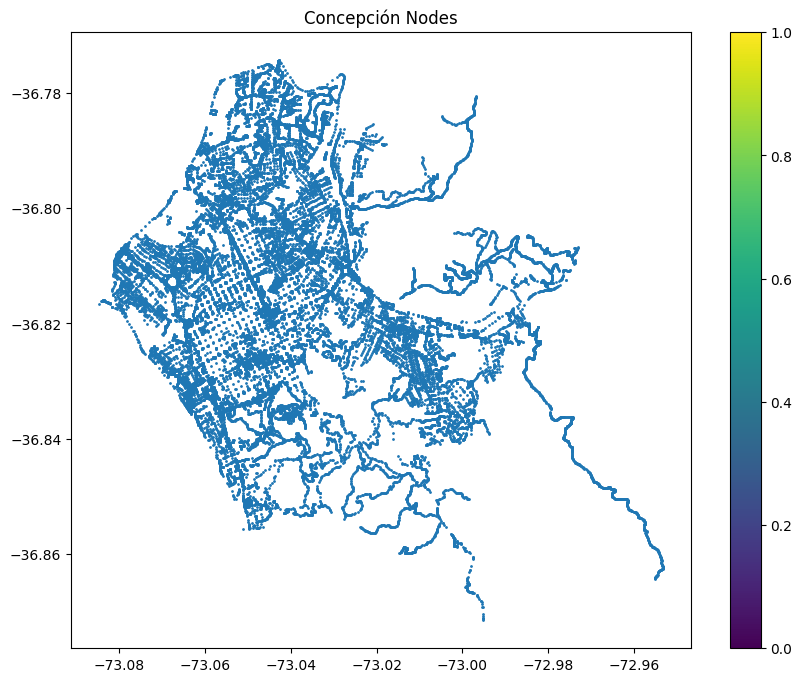

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Concepción Nodes')
plt.scatter(net.nodes_df.x, net.nodes_df.y, s=1, cmap='YlOrRd')
cb = plt.colorbar()

plt.show()

In [19]:
# Agrega el centroide a la grilla y los puntos (x,y)
grid['centroid'] = grid['geometry'].centroid
grid['x'] = grid['centroid'].x
grid['y'] = grid['centroid'].y

# Agrega los puntos (x,y) de los pois
pois['x'] = pois['geometry'].x
pois['y'] = pois['geometry'].y

In [20]:
grid['nearest_node'] = net.get_node_ids(grid['x'], grid['y'])
pois['nearest_node'] = net.get_node_ids(pois['x'], pois['y'])